In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('../../')
from Plots import plot_best_episode, plot_populations, plot_pulses
from Pulses import STA_pulses
from QEnvs.QEnvWave import QEnvWave
from QEnvs.QEnvDecay import QEnvDecay

2023-06-19 12:56:06.604454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 12:56:07.323580: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 3 levels system 18.22 [0., 0.2, 0.] max 1
# 4 levels system 20.11 [0., 0.165, 0.165, 0.] max 1.75
# 5 levels system 22 [0., 0.13, 0.13, 0.13, 0.] max 2.5

In [3]:
num_qubits=3
alpha_max = 1#/np.sqrt(2)
omega_max=2.5/10
time_max = 22
num_steps=50
gamma = 1.
decay_factors = [0., gamma, 0.]

In [4]:
def dummy_cost_function(env):
    return 0.0

def calculate_populations(env, pulse):
    times = env.times
    populations = []
    for state in env.run_qevolution(pulse):
        populations.append(np.abs(state)**2)
    return times, np.array(populations).reshape((num_steps, num_qubits))

Max pulses:  0.9999999998777066
Max intermediate population:  0.04003639984444828
Final population:  0.716380526240917


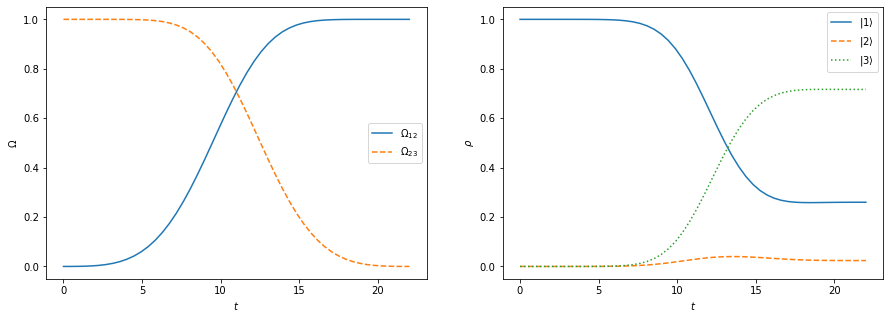

In [5]:
env = QEnvWave(num_qubits=num_qubits,
                   time_max=time_max,
                   num_steps=num_steps - 1,
                   cost_function=dummy_cost_function,
                   deltas=np.array([0., 3., 0.]))
pulses_sta = STA_pulses(num_qubits, time_max, num_steps, alpha_max, omega_max, sigma=time_max/6)
times_sta, populations_sta = calculate_populations(env, pulses_sta)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_pulses(times_sta, pulses_sta, ax=ax[0])
plot_populations(times_sta, populations_sta, ax=ax[1])
print("Max pulses: ", np.max(pulses_sta))
print("Max intermediate population: ", np.max(populations_sta.T[1:-1]))
print("Final population: ", populations_sta[-1][-1])

In [42]:
def calculate_populations(env, pulse):
    times = env.times
    populations = []
    for state in env.run_qevolution(pulse):
        populations.append(np.abs(np.diag(state)))
    return times, np.array(populations)

In [43]:
env = QEnvDecay(num_qubits=num_qubits,
                   time_max=time_max,
                   num_steps=num_steps - 1,
                   cost_function=dummy_cost_function,
                   decay_factors=decay_factors)
times_sta, populations_sta = calculate_populations(env, pulses_sta)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_pulses(times_sta, pulses_sta, ax=ax[0])
plot_populations(times_sta, populations_sta, ax=ax[1])
print("Max pulses: ", np.max(pulses_sta))
print("Max intermediate population: ", np.max(populations_sta.T[1:-2]))
print("Final population: ", populations_sta[-1][-2])

ValueError: Number of decay factors must be equal to the number of number of qubits.

In [ ]:
# 0.75 5 234
# 0.95 5 24


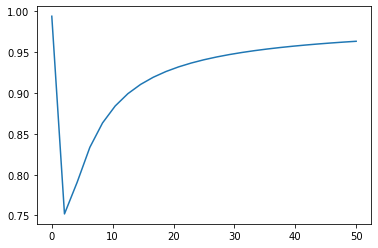

In [60]:
fidelity = []
for gamma in np.linspace(0., 50., 25):
    decay_factors = [0., gamma, gamma, gamma, 0.]
    env = QEnvDecay(num_qubits=num_qubits,
                    time_max=time_max,
                    num_steps=num_steps - 1,
                    cost_function=dummy_cost_function,
                    decay_factors=decay_factors)
    times_sta, populations_sta = calculate_populations(env, pulses_sta)
    fidelity.append(populations_sta[-1][-2])

plt.plot(np.linspace(0., 50., 25), fidelity)

In [61]:
np.linspace(0., 50., 25)[np.argmin(np.abs(np.array(fidelity) - 0.75))]

2.0833333333333335

In [10]:
np.save('Data/fidelity_sta.npy', fidelity)

In [13]:
pulses = pulses_sta
result = 0.
for i in range(num_steps):
    result += np.sqrt(np.sum(pulses[i]**2))
omega_0 = result/(np.sqrt(num_qubits-1)*num_steps)
omega_0

0.9641227624135085

In [301]:
pulses_res = omega_0*np.ones((num_steps, num_qubits-1))
result_res = 0.
for i in range(num_steps):
    result_res += np.sqrt(np.sum(pulses_res[i]**2))

print(result)
print(result_res)

192.8245524827017
192.8245524827019


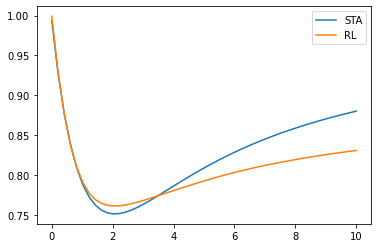

In [18]:
fidelity_sta = np.load('Data/fidelity_sta.npy')
fidelity_rl = np.load('Data/fidelity_rl.npy')

plt.plot(np.linspace(0., 10., 50), fidelity_sta, label='STA')
plt.plot(np.linspace(0., 10., 50), fidelity_rl, label='RL')
plt.legend()